In [2]:
import ROOT, os

Welcome to JupyROOT 6.30/07


[#1] INFO:DataHandling -- RooAbsReal::attachToTree(fit_mass) TTree Float_t branch fit_mass will be converted to double precision.
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(weight) TTree Float_t branch weight will be converted to double precision.
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(jet_mass) TTree Float_t branch jet_mass will be converted to double precision.
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(tagger) TTree Float_t branch tagger will be converted to double precision.
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_region) Skipping event #0 because fit_mass cannot accommodate the value 643.904
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_region) Skipping event #1 because fit_mass cannot accommodate the value 548.344
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_region) Skipping event #4 because fit_mass cannot accommodate the value 542.411
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_region) 

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       6067.723909 Edm =       2529.199656 NCalls =      9
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 4074.642164
  Edm           : 953.3836909
  Internal parameters:	[    -0.5521765089     0.6435011088]	
  Internal gradient  :	[     -3533.088634     -4092.553868]	
  Internal covariance matrix:
[[  0.00017577118              0]
 [              0  9.6688369e-05]]]
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 4074.642164
  Edm           : 953.3836909
  Internal parameters:	[    -0.5521765089     0.6435011088]	
  Internal gradient  :	[     -3533.088634     -4092.553868]	
  Internal covariance matrix:
[[  0.00017577118              0]
 [              0  9.6688369e-05]]]
Info in 

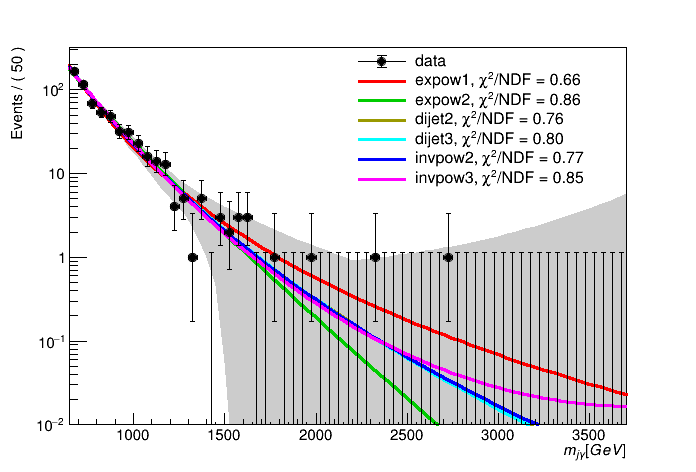

In [22]:
SR = 'SR1'
jet='Z'
x_min=650
x_max=3700
bin_width=50
tagger_cut = {
    'down': {'SR1': 0.8, 'SR2': 0.98},
    'up': {'SR1': 0.98, 'SR2': 2}
}
mass_cut = {
    'Z': [80, 110],
    'H': [110, 150]
}

CR_cut = f"""(
    (((jet_mass>50) & (jet_mass<80)) | (jet_mass>150)) & 
    (tagger>{tagger_cut['down'][SR]}) & (tagger<{tagger_cut['up'][SR]})
)"""
SR_cut = f"""(
    (jet_mass>{mass_cut[jet][0]}) & (jet_mass<{mass_cut[jet][1]}) & 
    (tagger>{tagger_cut['down'][SR]}) & (tagger<{tagger_cut['up'][SR]})
)"""


# Read files
f = ROOT.TFile(f"input/Run2/data.root", "r")
tree = f.Get("Events")
fit_mass = ROOT.RooRealVar("fit_mass", "fit_mass", 1500, x_min, x_max)
weight = ROOT.RooRealVar("weight", "weight", 1, -10, 10)
jet_mass = ROOT.RooRealVar("jet_mass", "jet_mass", 125, 0, 999)
tagger = ROOT.RooRealVar("tagger", "tagger", 0.5, 0, 2)
data_region = ROOT.RooDataSet("data_region", "data_region", tree, ROOT.RooArgSet(fit_mass, weight, jet_mass, tagger), SR_cut, "weight")

model, p1, p2, p3, result = {}, {}, {}, {}, {}

# dijet2 model
p1['dijet2'] = ROOT.RooRealVar("p1", "p1", 1, -10, 100)
p2['dijet2'] = ROOT.RooRealVar("p2", "p2", -2, -10, 0)
model['dijet2'] = ROOT.RooGenericPdf("model_background_dijet2", "model_background_dijet2", f"TMath::Power(@0, @1 + @2 * TMath::Log(@0))", ROOT.RooArgList(fit_mass, p1['dijet2'], p2['dijet2']))

# dijet3 model
p1['dijet3'] = ROOT.RooRealVar("p1", "p1", 1, -10, 100)
p2['dijet3'] = ROOT.RooRealVar("p2", "p2", -0.1, -10, 10)
p3['dijet3'] = ROOT.RooRealVar("p3", "p3", -0.1, -2, 1)
model['dijet3'] = ROOT.RooGenericPdf("model_background_dijet3", "model_background_dijet3", f"TMath::Power(@0, @1 + @2 * TMath::Log(@0) + @3 * TMath::Power(TMath::Log(@0), 2))", ROOT.RooArgList(fit_mass, p1['dijet3'], p2['dijet3'], p3['dijet3']))

# expow1 model
p1['expow1'] = ROOT.RooRealVar("p1", "p1", -0.1, -10, 0)
model['expow1'] = ROOT.RooGenericPdf("model_background_expow1", "model_background_expow1", f"TMath::Power(@0, @1)", ROOT.RooArgList(fit_mass, p1['expow1']))


# expow2 model
p1['expow2'] = ROOT.RooRealVar("p1", "p1", 2, -10, 10)
p2['expow2'] = ROOT.RooRealVar("p2", "p2", -0.1, -5, 5)
model['expow2'] = ROOT.RooGenericPdf("model_background_expow2", "model_background_expow2", f"TMath::Power(@0, @1) * TMath::Exp(@2 * @0)", ROOT.RooArgList(fit_mass, p1['expow2'], p2['expow2']))

# invpow2 model
p1['invpow2'] = ROOT.RooRealVar("p1", "p1", 1e-5, -1e-1, 1e-1)
p2['invpow2'] = ROOT.RooRealVar("p2", "p2", -1e2, -2e3, 0)
model['invpow2'] = ROOT.RooGenericPdf("model_background_invpow2", "model_background_invpow2", f"TMath::Power(1 + @1*@0, @2)", ROOT.RooArgList(fit_mass, p1['invpow2'], p2['invpow2']))

# invpow3 model
p1['invpow3'] = ROOT.RooRealVar("p1", "p1", 1e-4, -1, 1)
p2['invpow3'] = ROOT.RooRealVar("p2", "p2", -1e2, -1e3, 1e2)
p3['invpow3'] = ROOT.RooRealVar("p3", "p3", -1e-2, -1, 1)
model['invpow3'] = ROOT.RooGenericPdf("model_background_invpow3", "model_background_invpow3", f"TMath::Power(1 + @1*@0, @2 + @3*@0)", ROOT.RooArgList(fit_mass, p1['invpow3'], p2['invpow3'], p3['invpow3']))


for k in model:
    result[k] = model[k].fitTo(data_region, ROOT.RooFit.SumW2Error(True), Save=True)
    p1[k].setConstant(True)
    if k in p2:
        p2[k].setConstant(True)
    if k in p3:
        p3[k].setConstant(True)

candidates=['expow1', 'expow2', 'dijet2', 'dijet3', 'invpow2', 'invpow3']
fit_variable = fit_mass
bins = int((x_max-x_min)/bin_width)
plot_name = (candidates[0] if len(candidates) == 1 else f"{len(candidates)}")
canvas = ROOT.TCanvas()

frame = fit_variable.frame(Bins=bins)
data_region.plotOn(frame)

legend = ROOT.TLegend(0.5, 0.6, 0.89, 0.89)
#legend.SetTextSize(0.05)
legend.SetBorderSize(0)
legend.AddEntry(frame.getObject(0), "data", "lep")

for k in candidates:
    model[k].plotOn(frame, VisualizeError=(result[k], 1), FillColor='kGray')
#legend.AddEntry(frame.getObject(1), 'Stats. Unc.', "f")


for i, k in enumerate(candidates):
    model[k].plotOn(frame, LineColor=line_color[k])
    # Extract chi-square and NDF
    chi2_ndf = frame.chiSquare(len(result[k].floatParsFinal()))

    # Add entry to legend with chi2/ndf
    legend.AddEntry(frame.getObject(i + len(candidates) + 1), f"{k}, #chi^{{2}}/NDF = {chi2_ndf:.2f}", "l")

data_region.plotOn(frame)

canvas.SetLogy()
frame.SetMinimum(1e-2)
frame.SetTitle("")
frame.GetXaxis().SetTitle('m_{j\gamma} [GeV]')
frame.Draw()

legend.Draw()

if not os.path.exists('../plots/fit/Run2'):
    os.makedirs('../plots/fit/Run2')

if not os.path.exists('../plots/fit/Run2'):
    os.makedirs('../plots/fit/Run2')
canvas.SaveAs(f"../plots/fit/Run2/{SR}_{jet}_{plot_name}_errorband.pdf")


x = {}
y = {}

obj = frame.getObject(0)
x['data'] = []
y['data'] = []
for j in range(obj.GetN()):
    x['data'].append(obj.GetX()[j])
    y['data'].append(obj.GetY()[j])

for i, k in enumerate(candidates):
    obj = frame.getObject(i+1)
    x[k] = {'up': [], 'low': [], 'center': []}
    y[k] = {'up': [], 'low': [], 'center': []}
    for j in range(obj.GetN()):
        if j < obj.GetN()/2:
            x[k]['up'].append(obj.GetX()[j])
            y[k]['up'].append(obj.GetY()[j])
        else:
            x[k]['low'].append(obj.GetX()[j])
            y[k]['low'].append(obj.GetY()[j])

    obj = frame.getObject(i+1+len(candidates))
    for j in range(obj.GetN()):
        x[k]['center'].append(obj.GetX()[j])
        y[k]['center'].append(obj.GetY()[j])

In [3]:
def background_fit(SR, jet):
    tagger_cut = {
        'down': {'SR1': 0.8, 'SR2': 0.98},
        'up': {'SR1': 0.98, 'SR2': 2}
    }
    mass_cut = {
        'Z': [80, 110],
        'H': [110, 150]
    }

    CR_cut = f"""(
        (((jet_mass>50) & (jet_mass<80)) | (jet_mass>150)) & 
        (tagger>{tagger_cut['down'][SR]}) & (tagger<{tagger_cut['up'][SR]})
    )"""
    SR_cut = f"""(
        (jet_mass>{mass_cut[jet][0]}) & (jet_mass<{mass_cut[jet][1]}) & 
        (tagger>{tagger_cut['down'][SR]}) & (tagger<{tagger_cut['up'][SR]})
    )"""


    # Read files
    f = ROOT.TFile(f"input/Run2/data.root", "r")
    tree = f.Get("Events")
    fit_mass = ROOT.RooRealVar("fit_mass", "fit_mass", 1500, 650, 4000)
    weight = ROOT.RooRealVar("weight", "weight", 1, -10, 10)
    jet_mass = ROOT.RooRealVar("jet_mass", "jet_mass", 125, 0, 999)
    tagger = ROOT.RooRealVar("tagger", "tagger", 0.5, 0, 2)
    data_region = ROOT.RooDataSet("data_region", "data_region", tree, ROOT.RooArgSet(fit_mass, weight, jet_mass, tagger), SR_cut, "weight")

    model, p1, p2, p3, result = {}, {}, {}, {}, {}

    # dijet2 model
    p1['dijet2'] = ROOT.RooRealVar("p1", "p1", 1, -10, 100)
    p2['dijet2'] = ROOT.RooRealVar("p2", "p2", -2, -10, 0)
    model['dijet2'] = ROOT.RooGenericPdf("model_background_dijet2", "model_background_dijet2", f"TMath::Power(@0, @1 + @2 * TMath::Log(@0))", ROOT.RooArgList(fit_mass, p1['dijet2'], p2['dijet2']))

    # dijet3 model
    p1['dijet3'] = ROOT.RooRealVar("p1", "p1", 1, -10, 100)
    p2['dijet3'] = ROOT.RooRealVar("p2", "p2", -0.1, -10, 10)
    p3['dijet3'] = ROOT.RooRealVar("p3", "p3", -0.1, -2, 1)
    model['dijet3'] = ROOT.RooGenericPdf("model_background_dijet3", "model_background_dijet3", f"TMath::Power(@0, @1 + @2 * TMath::Log(@0) + @3 * TMath::Power(TMath::Log(@0), 2))", ROOT.RooArgList(fit_mass, p1['dijet3'], p2['dijet3'], p3['dijet3']))

    # expow1 model
    p1['expow1'] = ROOT.RooRealVar("p1", "p1", -0.1, -10, 0)
    model['expow1'] = ROOT.RooGenericPdf("model_background_expow1", "model_background_expow1", f"TMath::Power(@0, @1)", ROOT.RooArgList(fit_mass, p1['expow1']))


    # expow2 model
    p1['expow2'] = ROOT.RooRealVar("p1", "p1", 2, -10, 10)
    p2['expow2'] = ROOT.RooRealVar("p2", "p2", -0.1, -5, 5)
    model['expow2'] = ROOT.RooGenericPdf("model_background_expow2", "model_background_expow2", f"TMath::Power(@0, @1) * TMath::Exp(@2 * @0)", ROOT.RooArgList(fit_mass, p1['expow2'], p2['expow2']))

    # invpow2 model
    p1['invpow2'] = ROOT.RooRealVar("p1", "p1", 1e-5, -1e-1, 1e-1)
    p2['invpow2'] = ROOT.RooRealVar("p2", "p2", -1e2, -2e3, 0)
    model['invpow2'] = ROOT.RooGenericPdf("model_background_invpow2", "model_background_invpow2", f"TMath::Power(1 + @1*@0, @2)", ROOT.RooArgList(fit_mass, p1['invpow2'], p2['invpow2']))

    # invpow3 model
    p1['invpow3'] = ROOT.RooRealVar("p1", "p1", 1e-4, -1, 1)
    p2['invpow3'] = ROOT.RooRealVar("p2", "p2", -1e2, -1e3, 1e2)
    p3['invpow3'] = ROOT.RooRealVar("p3", "p3", -1e-2, -1, 1)
    model['invpow3'] = ROOT.RooGenericPdf("model_background_invpow3", "model_background_invpow3", f"TMath::Power(1 + @1*@0, @2 + @3*@0)", ROOT.RooArgList(fit_mass, p1['invpow3'], p2['invpow3'], p3['invpow3']))


    for k in model:
        result[k] = model[k].fitTo(data_region, ROOT.RooFit.SumW2Error(True), Save=True)
        p1[k].setConstant(True)
        if k in p2:
            p2[k].setConstant(True)
        if k in p3:
            p3[k].setConstant(True)
    
    return model, result, fit_mass, data_region

In [4]:
line_color = {'expow1': ROOT.kRed, 'expow2': ROOT.kGreen+1, 'dijet2': ROOT.kYellow+2, 'dijet3': ROOT.kCyan, 'invpow2':ROOT.kBlue, 'invpow3': ROOT.kMagenta}
band_color = {'expow1': ROOT.kPink, 'expow2': ROOT.kYellow, 'dijet2': ROOT.kGreen, 'dijet3': ROOT.kCyan, 'invpow2':ROOT.kAzure, 'invpow3': ROOT.kMagenta}


def fit_error_band(candidates, model, result, fit_variable, data_region, SR, jet, x_min=650, x_max=3700, bin_width=50, line_color=line_color):
    bins = int((x_max-x_min)/bin_width)
    plot_name = (candidates[0] if len(candidates) == 1 else f"{len(candidates)}")
    canvas = ROOT.TCanvas()

    frame = fit_variable.frame(x_min, x_max, bins)
    data_region.plotOn(frame)

    legend = ROOT.TLegend(0.5, 0.6, 0.89, 0.89)
    #legend.SetTextSize(0.05)
    legend.SetBorderSize(0)
    legend.AddEntry(frame.getObject(0), "data", "lep")

    for k in candidates:
        model[k].plotOn(frame, VisualizeError=(result[k], 1), FillColor='kGray')
    #legend.AddEntry(frame.getObject(1), 'Stats. Unc.', "f")


    for i, k in enumerate(candidates):
        model[k].plotOn(frame, LineColor=line_color[k])
        # Extract chi-square and NDF
        chi2_ndf = frame.chiSquare(len(result[k].floatParsFinal()))

        # Add entry to legend with chi2/ndf
        legend.AddEntry(frame.getObject(i + len(candidates) + 1), f"{k}, #chi^{{2}}/NDF = {chi2_ndf:.2f}", "l")

    data_region.plotOn(frame)
    
    canvas.SetLogy()
    frame.SetMinimum(1e-2)
    frame.SetTitle("")
    frame.GetXaxis().SetTitle('m_{j\gamma} [GeV]')
    frame.Draw()

    legend.Draw()

    if not os.path.exists('../plots/fit/Run2'):
        os.makedirs('../plots/fit/Run2')

    if not os.path.exists('../plots/fit/Run2'):
        os.makedirs('../plots/fit/Run2')
    canvas.SaveAs(f"../plots/fit/Run2/{SR}_{jet}_{plot_name}_errorband.pdf")


    x = {}
    y = {}

    obj = frame.getObject(0)
    x['data'] = []
    y['data'] = []
    for j in range(obj.GetN()):
        x['data'].append(obj.GetX()[j])
        y['data'].append(obj.GetY()[j])

    for i, k in enumerate(candidates):
        obj = frame.getObject(i+1)
        x[k] = {'up': [], 'low': [], 'center': []}
        y[k] = {'up': [], 'low': [], 'center': []}
        for j in range(obj.GetN()):
            if j < obj.GetN()/2:
                x[k]['up'].append(obj.GetX()[j])
                y[k]['up'].append(obj.GetY()[j])
            else:
                x[k]['low'].append(obj.GetX()[j])
                y[k]['low'].append(obj.GetY()[j])

        obj = frame.getObject(i+1+len(candidates))
        for j in range(obj.GetN()):
            x[k]['center'].append(obj.GetX()[j])
            y[k]['center'].append(obj.GetY()[j])

    return frame.getObject(1)

In [5]:
def main(SR, jet, x_max=3700, x_min=650, bin_width=50):
    tagger_cut = {
        'down': {'SR1': 0.8, 'SR2': 0.98},
        'up': {'SR1': 0.98, 'SR2': 2}
    }
    mass_cut = {
        'Z': [80, 110],
        'H': [110, 150]
    }

    CR_cut = f"""(
        (((jet_mass>50) & (jet_mass<80)) | (jet_mass>150)) & 
        (tagger>{tagger_cut['down'][SR]}) & (tagger<{tagger_cut['up'][SR]})
    )"""
    SR_cut = f"""(
        (jet_mass>{mass_cut[jet][0]}) & (jet_mass<{mass_cut[jet][1]}) & 
        (tagger>{tagger_cut['down'][SR]}) & (tagger<{tagger_cut['up'][SR]})
    )"""


    # Read files
    f = ROOT.TFile(f"input/Run2/data.root", "r")
    tree = f.Get("Events")
    fit_mass = ROOT.RooRealVar("fit_mass", "fit_mass", 1500, x_min, x_max)
    weight = ROOT.RooRealVar("weight", "weight", 1, -10, 10)
    jet_mass = ROOT.RooRealVar("jet_mass", "jet_mass", 125, 0, 999)
    tagger = ROOT.RooRealVar("tagger", "tagger", 0.5, 0, 2)
    data_region = ROOT.RooDataSet("data_region", "data_region", tree, ROOT.RooArgSet(fit_mass, weight, jet_mass, tagger), SR_cut, "weight")

    model, p1, p2, p3, result = {}, {}, {}, {}, {}

    # dijet2 model
    p1['dijet2'] = ROOT.RooRealVar("p1", "p1", 1, -10, 100)
    p2['dijet2'] = ROOT.RooRealVar("p2", "p2", -2, -10, 0)
    model['dijet2'] = ROOT.RooGenericPdf("model_background_dijet2", "model_background_dijet2", f"TMath::Power(@0, @1 + @2 * TMath::Log(@0))", ROOT.RooArgList(fit_mass, p1['dijet2'], p2['dijet2']))

    # dijet3 model
    p1['dijet3'] = ROOT.RooRealVar("p1", "p1", 1, -10, 100)
    p2['dijet3'] = ROOT.RooRealVar("p2", "p2", -0.1, -10, 10)
    p3['dijet3'] = ROOT.RooRealVar("p3", "p3", -0.1, -2, 1)
    model['dijet3'] = ROOT.RooGenericPdf("model_background_dijet3", "model_background_dijet3", f"TMath::Power(@0, @1 + @2 * TMath::Log(@0) + @3 * TMath::Power(TMath::Log(@0), 2))", ROOT.RooArgList(fit_mass, p1['dijet3'], p2['dijet3'], p3['dijet3']))

    # expow1 model
    p1['expow1'] = ROOT.RooRealVar("p1", "p1", -0.1, -10, 0)
    model['expow1'] = ROOT.RooGenericPdf("model_background_expow1", "model_background_expow1", f"TMath::Power(@0, @1)", ROOT.RooArgList(fit_mass, p1['expow1']))


    # expow2 model
    p1['expow2'] = ROOT.RooRealVar("p1", "p1", 2, -10, 10)
    p2['expow2'] = ROOT.RooRealVar("p2", "p2", -0.1, -5, 5)
    model['expow2'] = ROOT.RooGenericPdf("model_background_expow2", "model_background_expow2", f"TMath::Power(@0, @1) * TMath::Exp(@2 * @0)", ROOT.RooArgList(fit_mass, p1['expow2'], p2['expow2']))

    # invpow2 model
    p1['invpow2'] = ROOT.RooRealVar("p1", "p1", 1e-5, -1e-1, 1e-1)
    p2['invpow2'] = ROOT.RooRealVar("p2", "p2", -1e2, -2e3, 0)
    model['invpow2'] = ROOT.RooGenericPdf("model_background_invpow2", "model_background_invpow2", f"TMath::Power(1 + @1*@0, @2)", ROOT.RooArgList(fit_mass, p1['invpow2'], p2['invpow2']))

    # invpow3 model
    p1['invpow3'] = ROOT.RooRealVar("p1", "p1", 1e-4, -1, 1)
    p2['invpow3'] = ROOT.RooRealVar("p2", "p2", -1e2, -1e3, 1e2)
    p3['invpow3'] = ROOT.RooRealVar("p3", "p3", -1e-2, -1, 1)
    model['invpow3'] = ROOT.RooGenericPdf("model_background_invpow3", "model_background_invpow3", f"TMath::Power(1 + @1*@0, @2 + @3*@0)", ROOT.RooArgList(fit_mass, p1['invpow3'], p2['invpow3'], p3['invpow3']))


    for k in model:
        result[k] = model[k].fitTo(data_region, ROOT.RooFit.SumW2Error(True), Save=True)
        p1[k].setConstant(True)
        if k in p2:
            p2[k].setConstant(True)
        if k in p3:
            p3[k].setConstant(True)

    for k in ['expow1', 'expow2', 'dijet2', 'dijet3', 'invpow2', 'invpow3']:
        fit_error_band(candidates=[k], model=model, result=result, fit_variable=fit_mass, data_region=data_region, SR=SR, jet=jet, x_min=x_min, x_max=x_max, bin_width=bin_width)

    return fit_error_band(candidates=['expow1', 'expow2', 'dijet2', 'dijet3', 'invpow2', 'invpow3'], model=model, result=result, fit_variable=fit_mass, data_region=data_region, SR=SR, jet=jet, x_min=x_min, x_max=x_max, bin_width=bin_width)

In [6]:
for SR in ['SR1', 'SR2']:
    for jet in ['H', 'Z']:
        errorband = main(SR, jet)

[#1] INFO:DataHandling -- RooAbsReal::attachToTree(fit_mass) TTree Float_t branch fit_mass will be converted to double precision.
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(weight) TTree Float_t branch weight will be converted to double precision.
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(jet_mass) TTree Float_t branch jet_mass will be converted to double precision.
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(tagger) TTree Float_t branch tagger will be converted to double precision.
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_region) Skipping event #0 because fit_mass cannot accommodate the value 643.904
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_region) Skipping event #1 because fit_mass cannot accommodate the value 548.344
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_region) Skipping event #4 because fit_mass cannot accommodate the value 542.411
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_region) 

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =        5159.29482 Edm =       2279.007342 NCalls =      9
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 3137.56654
  Edm           : 86.20402128
  Internal parameters:	[    -0.4574590413     0.6435011088]	
  Internal gradient  :	[     -1675.270993     -1844.147502]	
  Internal covariance matrix:
[[  6.3260909e-05              0]
 [              0  4.9184994e-05]]]
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 3137.56654
  Edm           : 86.20402128
  Internal parameters:	[    -0.4574590413     0.6435011088]	
  Internal gradient  :	[     -1675.270993     -1844.147502]	
  Internal covariance matrix:
[[  6.3260909e-05              0]
 [              0  4.9184994e-05]]]
Info in <M

# Scratch

In [ ]:
model, p1, p2, p3, result = {}, {}, {}, {}, {}

energy = 1.3e4

# dijet2 model
p1['dijet2'] = ROOT.RooRealVar("p1", "p1", 1, -50, 50)
p2['dijet2'] = ROOT.RooRealVar("p2", "p2", 1, -10, 10)
model['dijet2'] = ROOT.RooGenericPdf("model_background_dijet2", "model_background_dijet2", f"TMath::Power(@0/{energy}, @1 + @2 * TMath::Log(@0/{energy}))", ROOT.RooArgList(fit_mass, p1['dijet2'], p2['dijet2']))

# dijet3 model
p1['dijet3'] = ROOT.RooRealVar("p1", "p1", 1, -100, 100)
p2['dijet3'] = ROOT.RooRealVar("p2", "p2", 1, -100, 100)
p3['dijet3'] = ROOT.RooRealVar("p3", "p3", 1e-1, -10, 10)
model['dijet3'] = ROOT.RooGenericPdf("model_background_dijet3", "model_background_dijet3", f"TMath::Power(@0/{energy}, @1 + @2 * TMath::Log(@0/{energy}) + @3 * TMath::Power(TMath::Log(@0/{energy}), 2))", ROOT.RooArgList(fit_mass, p1['dijet3'], p2['dijet3'], p3['dijet3']))

# expow1 model
p1['expow1'] = ROOT.RooRealVar("p1", "p1", -1, -10, 10)
model['expow1'] = ROOT.RooGenericPdf("model_background_expow1", "model_background_expow1", f"TMath::Power(@0/{energy}, @1)", ROOT.RooArgList(fit_mass, p1['expow1']))

# expow2 model
p1['expow2'] = ROOT.RooRealVar("p1", "p1", -1, -100, 100)
p2['expow2'] = ROOT.RooRealVar("p2", "p2", -1, -200, 200)
model['expow2'] = ROOT.RooGenericPdf("model_background_expow2", "model_background_expow2", f"TMath::Power(@0/{energy}, @1) * TMath::Exp(@2 * @0/{energy})", ROOT.RooArgList(fit_mass, p1['expow2'], p2['expow2']))

# invpow2 model
p1['invpow2'] = ROOT.RooRealVar("p1", "p1", 1, -100, 100)
p2['invpow2'] = ROOT.RooRealVar("p2", "p2", -1, -200, 200)
model['invpow2'] = ROOT.RooGenericPdf("model_background_invpow2", "model_background_invpow2", f"TMath::Power(1 + @1*@0/{energy}, @2)", ROOT.RooArgList(fit_mass, p1['invpow2'], p2['invpow2']))

# invpow3 model
p1['invpow3'] = ROOT.RooRealVar("p1", "p1", 1, -100, 100)
p2['invpow3'] = ROOT.RooRealVar("p2", "p2", -1, -200, 200)
p3['invpow3'] = ROOT.RooRealVar("p3", "p3", 1, -200, 100)
model['invpow3'] = ROOT.RooGenericPdf("model_background_invpow3", "model_background_invpow3", f"TMath::Power(1 + @1*@0/{energy}, @2 + @3*@0/{energy})", ROOT.RooArgList(fit_mass, p1['invpow3'], p2['invpow3'], p3['invpow3']))



for k in ['dijet2', 'dijet3', 'expow1', 'expow2', 'invpow2', 'invpow3']:
    result[k] = model[k].fitTo(data_region, ROOT.RooFit.SumW2Error(True), Save=True)
    p1[k].setConstant(True)
    if k in p2:
        p2[k].setConstant(True)
    if k in p3:
        p3[k].setConstant(True)